# YandexgGPT results in Centipede game

---



In [1]:
! pip3 install pymorphy3

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

## YandexGPT (первый ход)

В этом случае YandexGPT ходит первым, а его оппонент постоянно 'пасует'. Таким образом можно узнать, когда YandexGPT забирает стопку себе (ничья также возможна).

In [3]:
df = pd.read_csv('solo_results_llm_first_move.csv')

In [4]:
df.shape

(2076, 6)

In [5]:
df.sample(5)

game  round          player  \
1965  8ef2d7fe-2a32-4e04-aa08-69f432ded950      1  Пользователь_1   
128   437a67f9-f474-4fb3-99b6-6c98d160e891      1  Пользователь_1   
651   9d255cc3-4f73-474b-9e76-4787eea94447      2  Пользователь_2   
1221  c8eb385f-c51c-4386-8d23-b2d618374242      6  Пользователь_2   
1298  3144b313-9b10-4423-a57e-6cce80c901a4      1  Пользователь_1   

     emotional_state action                                        explanation  
1965            злой   take  \n\nзлость может подталкивать к рискованным ре...  
128         грустный   pass   так как это первый раунд, у меня нет информац...  
651          неважно   pass                                  без комментариев   
1221         неважно   pass                                  без комментариев   
1298        грустный   pass  \n\nгрустный игрок может решить не рисковать и...

In [6]:
df['emotional_state'].unique()

array(['радостный', 'грустный', 'неважно', 'гневный', 'испуганный',
       'удивленный', 'злой', 'нейтральный'], dtype=object)

In [7]:
# Можем выкинуть эти строки, так как они не влияют на дальнейший анализ (по сути избавились от 2-го игрока)
df = df[df['emotional_state'] != 'неважно']

#### Число игр для каждого эмоционального состояния (проверить баланс классов)

In [8]:
games_per_emotional_state = df.groupby('emotional_state')['game'].nunique().reset_index()
games_per_emotional_state.columns = ['emotional_state', 'Number_of_Games']
print('Total number of games played: ', games_per_emotional_state['Number_of_Games'].sum())
games_per_emotional_state

Total number of games played:  645


emotional_state  Number_of_Games
0         гневный               91
1        грустный              100
2            злой              100
3      испуганный              100
4     нейтральный               74
5       радостный               85
6      удивленный               95

#### Максимальное число раундов для каждого эмоционального состояния

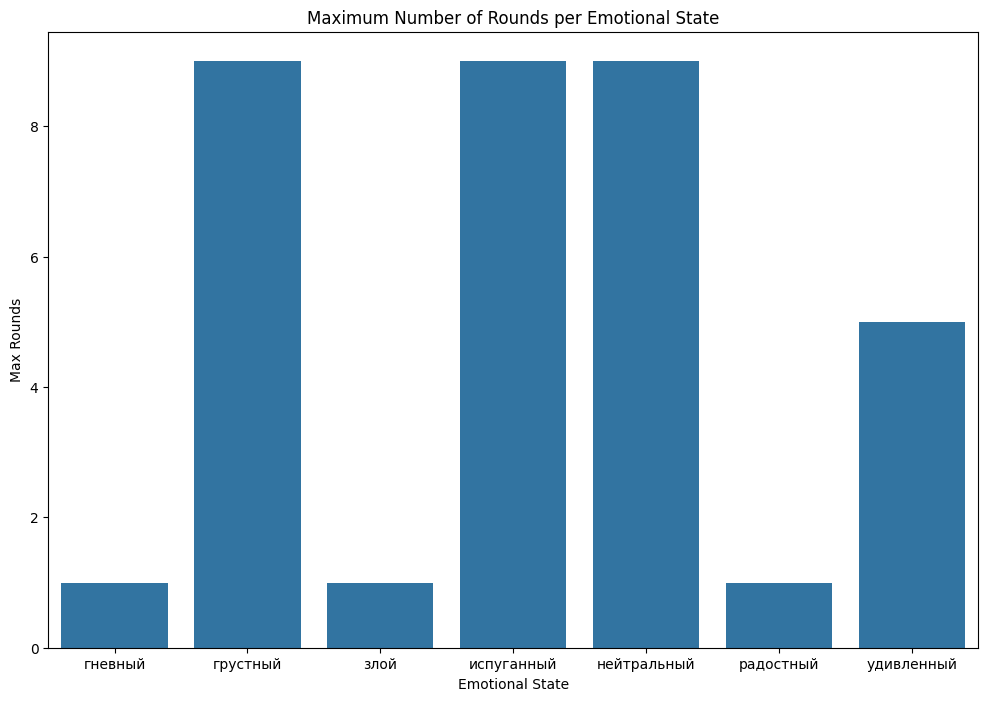

In [9]:
max_rounds_per_emotional_state = df.groupby('emotional_state')['round'].max().reset_index()
max_rounds_per_emotional_state.columns = ['emotional_state', 'max_round']

plt.figure(figsize=(12, 8))
sns.barplot(data=max_rounds_per_emotional_state, x='emotional_state', y='max_round')
plt.title('Maximum Number of Rounds per Emotional State')
plt.xlabel('Emotional State')
plt.ylabel('Max Rounds')
plt.show()

#### Среднее число раундов для каждого эмоционального состояния

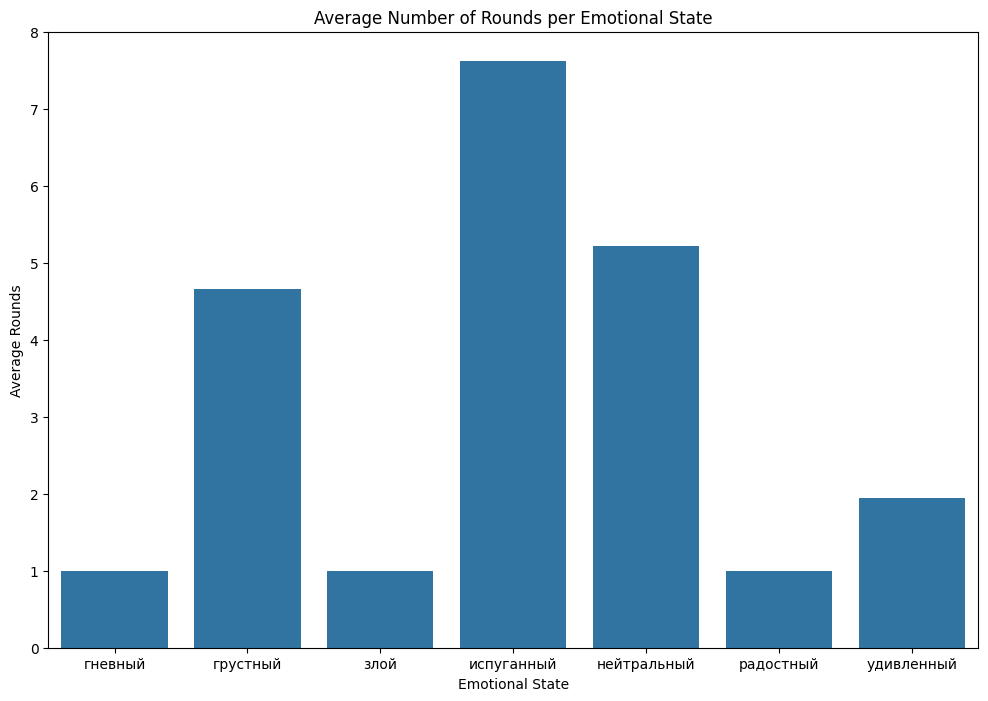

In [10]:
avg_rounds_per_emotional_state = df.groupby(['game', 'emotional_state'])['round'].max().reset_index().groupby(['emotional_state'])['round'].mean().reset_index()
avg_rounds_per_emotional_state.columns = ['emotional_state', 'avg_round']

plt.figure(figsize=(12, 8))
sns.barplot(data=avg_rounds_per_emotional_state, x='emotional_state', y='avg_round')
plt.title('Average Number of Rounds per Emotional State')
plt.xlabel('Emotional State')
plt.ylabel('Average Rounds')
plt.show()

In [11]:
avg_rounds_per_emotional_state

emotional_state  avg_round
0         гневный   1.000000
1        грустный   4.660000
2            злой   1.000000
3      испуганный   7.620000
4     нейтральный   5.216216
5       радостный   1.000000
6      удивленный   1.947368

#### Анализ объяснений выбора YandexGPT

In [12]:
df_grouped = df.groupby('emotional_state')['explanation'].apply(lambda x: ' '.join(x)).reset_index()

In [13]:
import re
import nltk
from nltk.corpus import stopwords
from pymorphy3 import MorphAnalyzer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

nltk.download('stopwords')
stop_words = set(stopwords.words('russian') + ['это', 'поскольку', 'поэтому'])
morph = MorphAnalyzer()

def preprocess_text(text):
    text = text.lower()
    # Убираем пунктуацию и числа
    text = re.sub(r'\W+', ' ', text)

    words = text.split()
    words = [morph.normal_forms(word)[0] for word in words if word not in stop_words]
    return ' '.join(words)

df['clean_explanation'] =  df['explanation'].apply(preprocess_text)
df_grouped['cleaned_explanation'] = df_grouped['explanation'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_grouped['cleaned_explanation'])
cosine_similarities = cosine_similarity(X, X)

similarity_df = pd.DataFrame(cosine_similarities, index=df_grouped['emotional_state'], columns=df_grouped['emotional_state'])

def get_similar_emotional_states(similarity_df, threshold=0.5):
    similar_states = []
    for i in range(len(similarity_df)):
        for j in range(i+1, len(similarity_df)):
            if similarity_df.iloc[i, j] > threshold:
                similar_states.append((similarity_df.index[i], similarity_df.index[j], similarity_df.iloc[i, j]))
    return similar_states

similar_states = get_similar_emotional_states(similarity_df, threshold=0.81)

In [15]:
similar_states

[('грустный', 'нейтральный', 0.9038633657476524),
 ('грустный', 'удивленный', 0.8261274026657947),
 ('нейтральный', 'радостный', 0.8195561141770003),
 ('нейтральный', 'удивленный', 0.8700762063644452)]

#### Какие слова имеют наибольший tf-idf?

Большой вес в TF-IDF получат слова с высокой частотой в пределах конкретного документа и с низкой частотой употреблений в других документах.

In [16]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_grouped['cleaned_explanation'])

feature_names = vectorizer.get_feature_names_out()

tfidf_sums = X.sum(axis=0).A1

tfidf_df = pd.DataFrame({'term': feature_names, 'tfidf_sum': tfidf_sums})

tfidf_df = tfidf_df.sort_values(by='tfidf_sum', ascending=False)

top_n = 15
top_terms = tfidf_df.head(top_n)

In [17]:
top_terms

term  tfidf_sum
311        монета   3.195739
815        стопка   2.395664
703         раунд   1.838200
209          игра   1.604816
41        больший   1.247005
69          взять   1.225517
428      оппонент   1.099641
476        первый   0.986192
533      получить   0.942852
212         игрок   0.853162
903           ход   0.746160
178       забрать   0.735602
605  преимущество   0.732493
245    испуганный   0.647028
136      действие   0.590051

#### Внутри каждого emotional state определим самые значимые слова

In [18]:
vectorizer = TfidfVectorizer()

top_5_words = {}

for emotional_state in df['emotional_state'].unique():
    state_df = df[df['emotional_state'] == emotional_state]
    tfidf_matrix = vectorizer.fit_transform(state_df['clean_explanation'])
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    mean_tfidf_scores = tfidf_df.mean(axis=0)
    top_5 = mean_tfidf_scores.nlargest(5).index.tolist()
    top_5_words[emotional_state] = top_5

for word in top_5_words.keys():
  print(word, top_5_words[word])

радостный ['монета', 'стопка', 'раунд', 'первый', 'взять']
грустный ['монета', 'стопка', 'раунд', 'игра', 'игрок']
гневный ['монета', 'стопка', 'взять', 'больший', 'раунд']
испуганный ['монета', 'игрок', 'испуганный', 'стопка', 'игра']
удивленный ['монета', 'раунд', 'стопка', 'игра', 'первый']
злой ['монета', 'стопка', 'получить', 'игра', 'преимущество']
нейтральный ['монета', 'стопка', 'раунд', 'игра', 'оппонент']


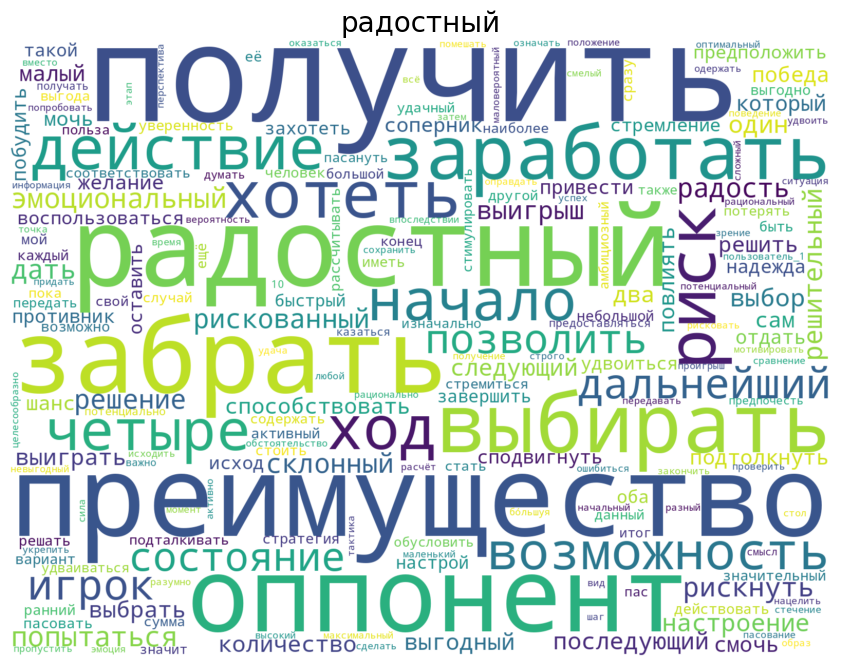

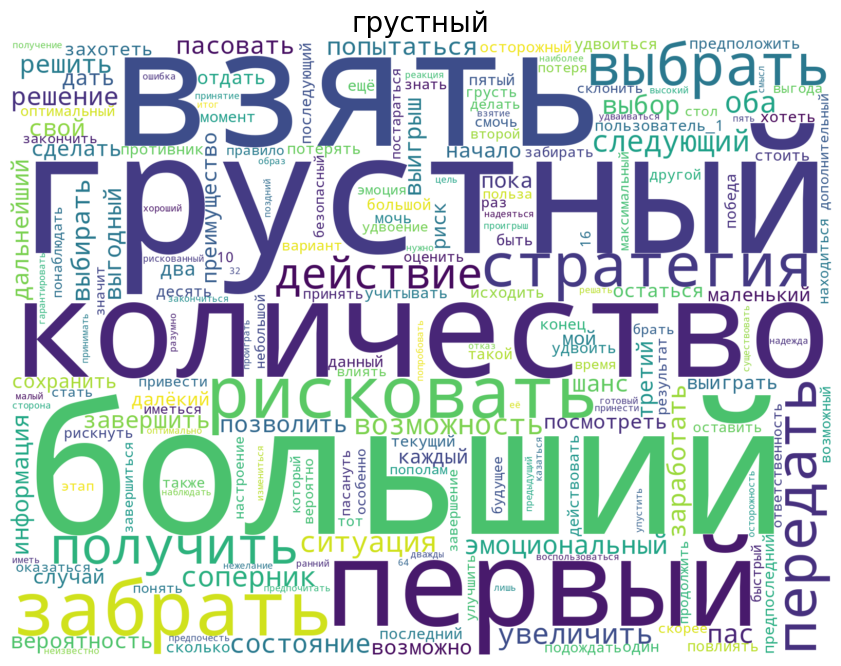

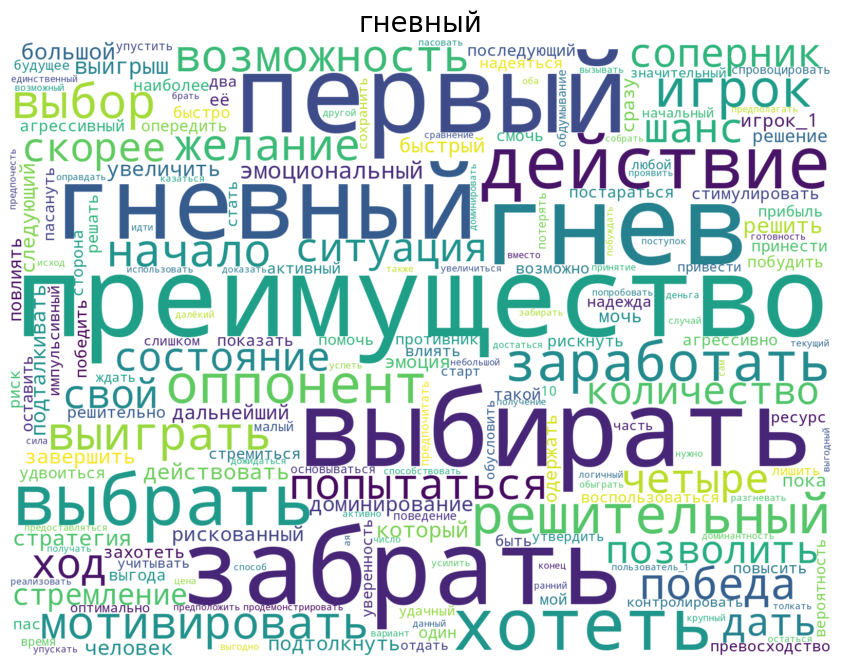

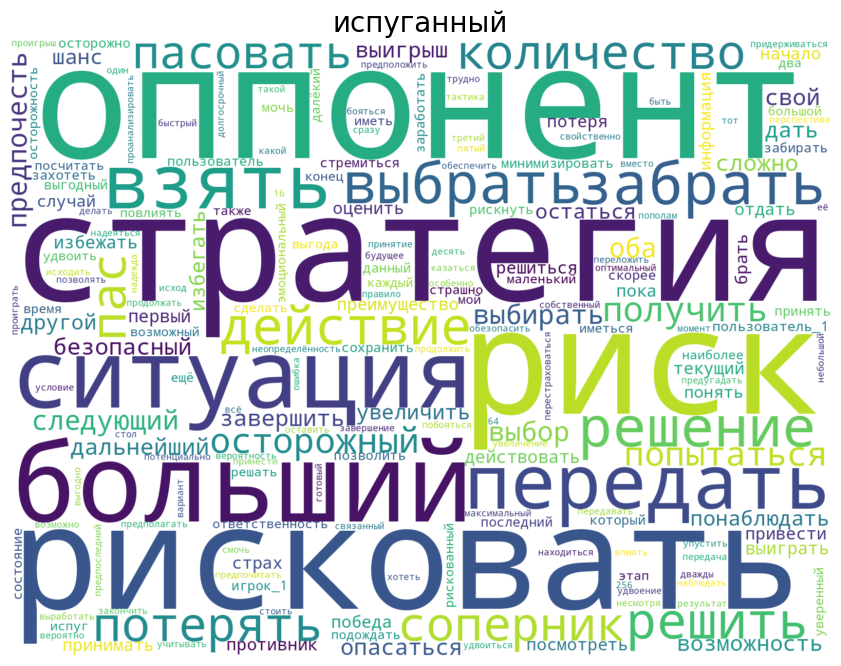

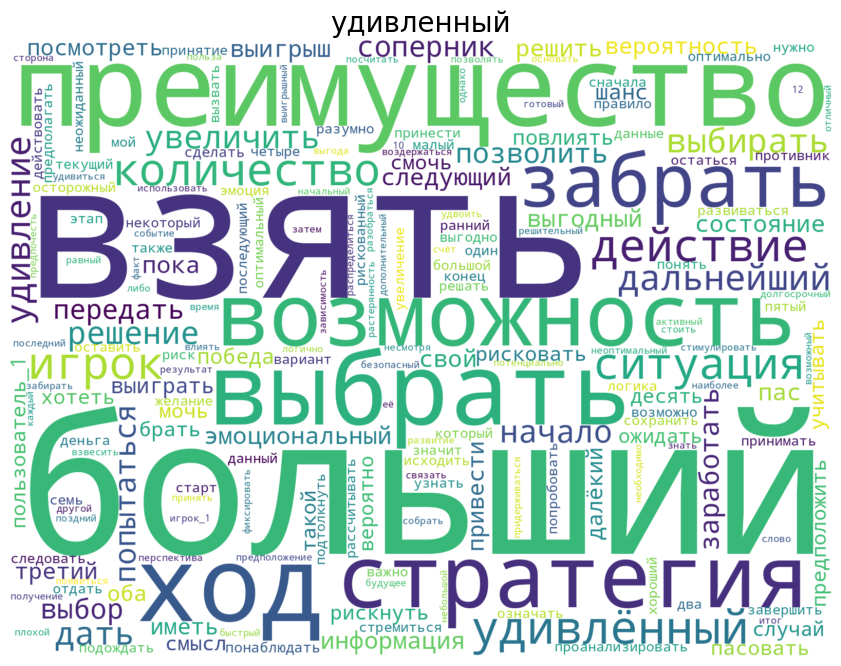

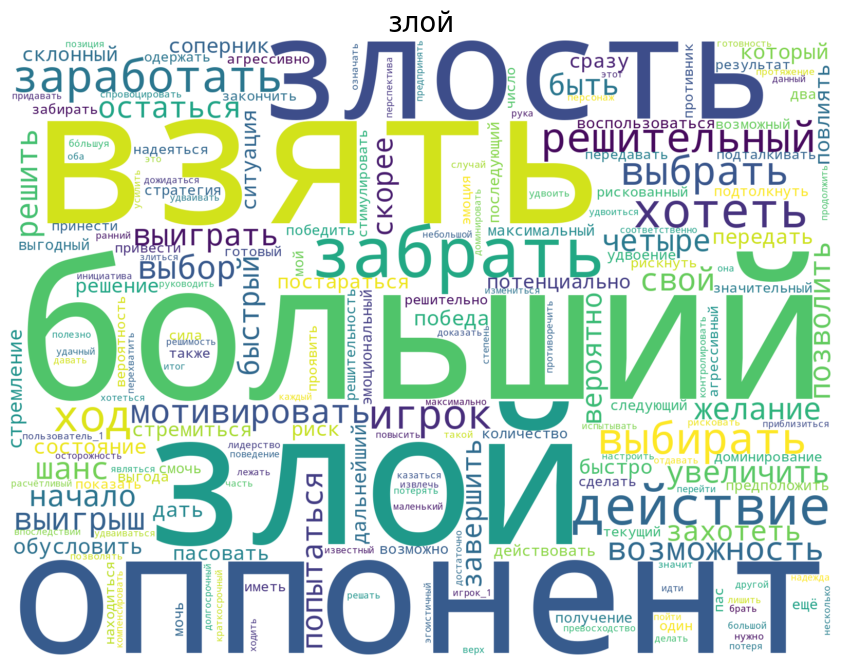

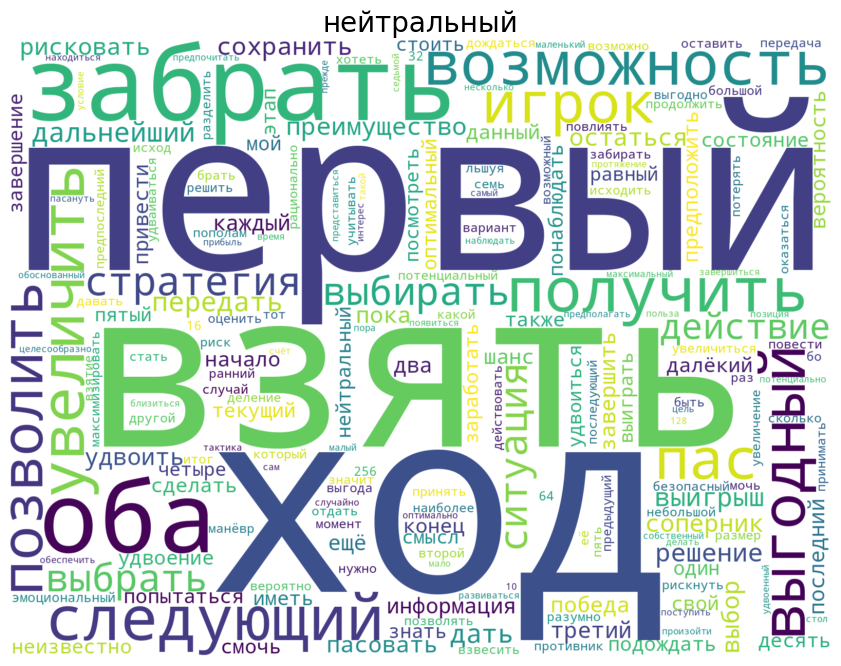

In [19]:
from wordcloud import WordCloud

vectorizer = TfidfVectorizer()

for emotional_state in df['emotional_state'].unique():
    state_df = df[df['emotional_state'] == emotional_state]
    tfidf_matrix = vectorizer.fit_transform(state_df['clean_explanation'])
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

    # Посчитать средний tf-idf для каждого слова
    mean_tfidf_scores = tfidf_df.mean(axis=0)

    # Убрать первые 7 самых популярных слова
    top_words = mean_tfidf_scores.nlargest(7).index
    filtered_tfidf_scores = mean_tfidf_scores.drop(top_words)

    wordcloud = WordCloud(width=1600, height=1200, background_color='white').generate_from_frequencies(filtered_tfidf_scores)

    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(emotional_state, fontsize=20)
    plt.axis('off')
    plt.show()


#### Разный trust level

Trust level = 0.9

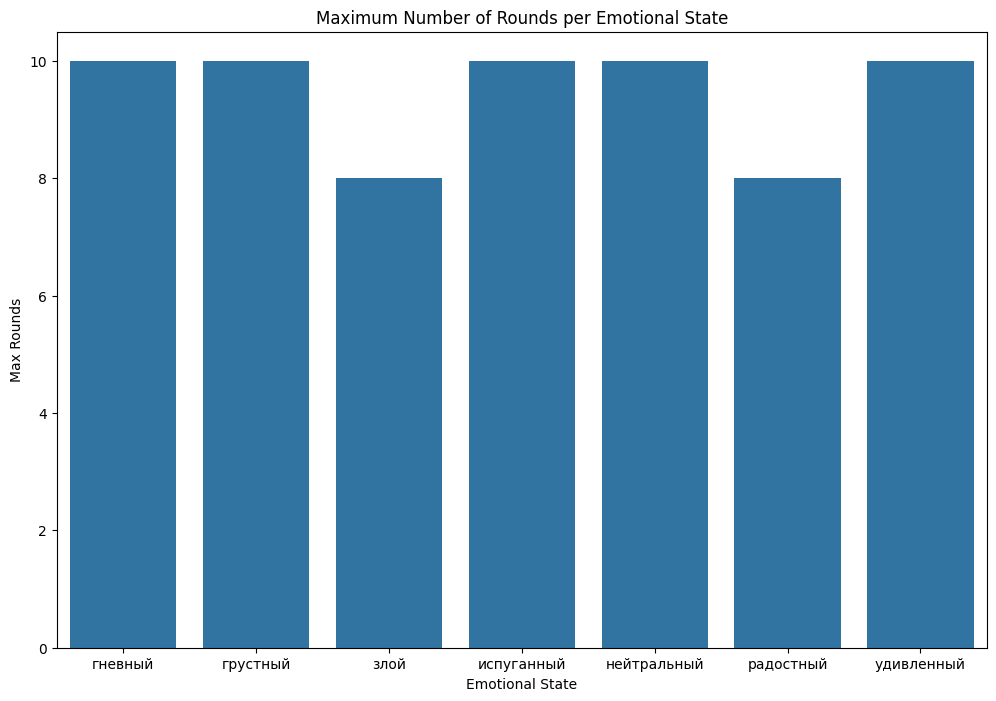

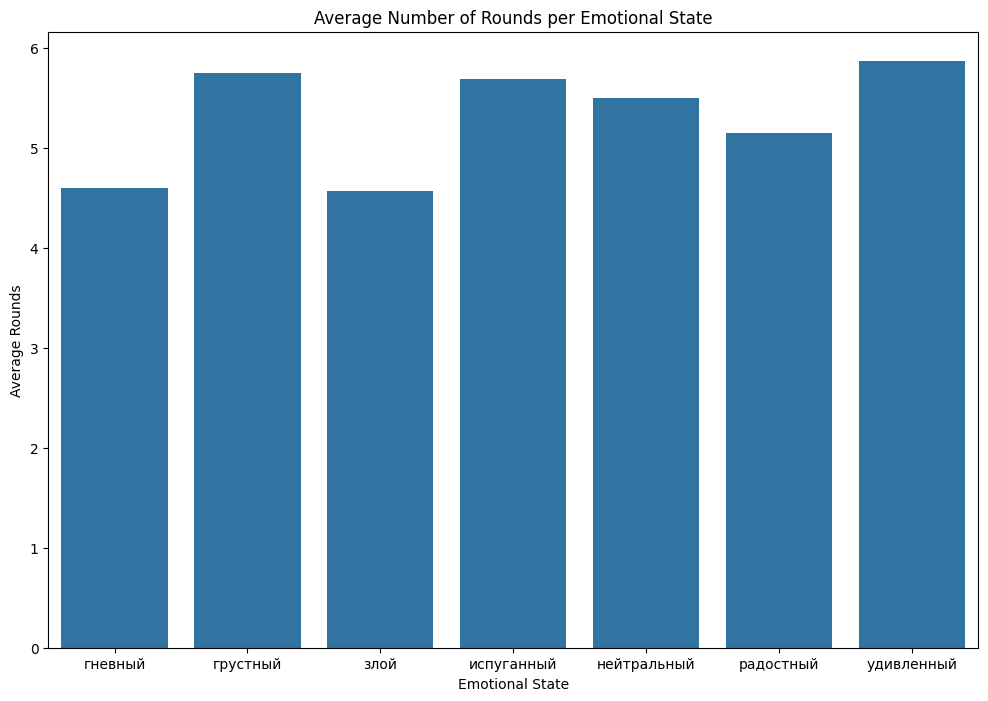

In [20]:
df = pd.read_csv('trust_0_9.csv')
df['emotional_state'] = df['emotional_state'].apply(lambda x: x.split(',')[0][2:-1])

max_rounds_per_emotional_state = df.groupby('emotional_state')['round'].max().reset_index()
max_rounds_per_emotional_state.columns = ['emotional_state', 'max_round']

plt.figure(figsize=(12, 8))
sns.barplot(data=max_rounds_per_emotional_state, x='emotional_state', y='max_round')
plt.title('Maximum Number of Rounds per Emotional State')
plt.xlabel('Emotional State')
plt.ylabel('Max Rounds')
plt.show()

avg_rounds_per_emotional_state = df.groupby(['game', 'emotional_state'])['round'].max().reset_index().groupby(['emotional_state'])['round'].mean().reset_index()
avg_rounds_per_emotional_state.columns = ['emotional_state', 'avg_round']

plt.figure(figsize=(12, 8))
sns.barplot(data=avg_rounds_per_emotional_state, x='emotional_state', y='avg_round')
plt.title('Average Number of Rounds per Emotional State')
plt.xlabel('Emotional State')
plt.ylabel('Average Rounds')
plt.show()

Trust level = 0.1

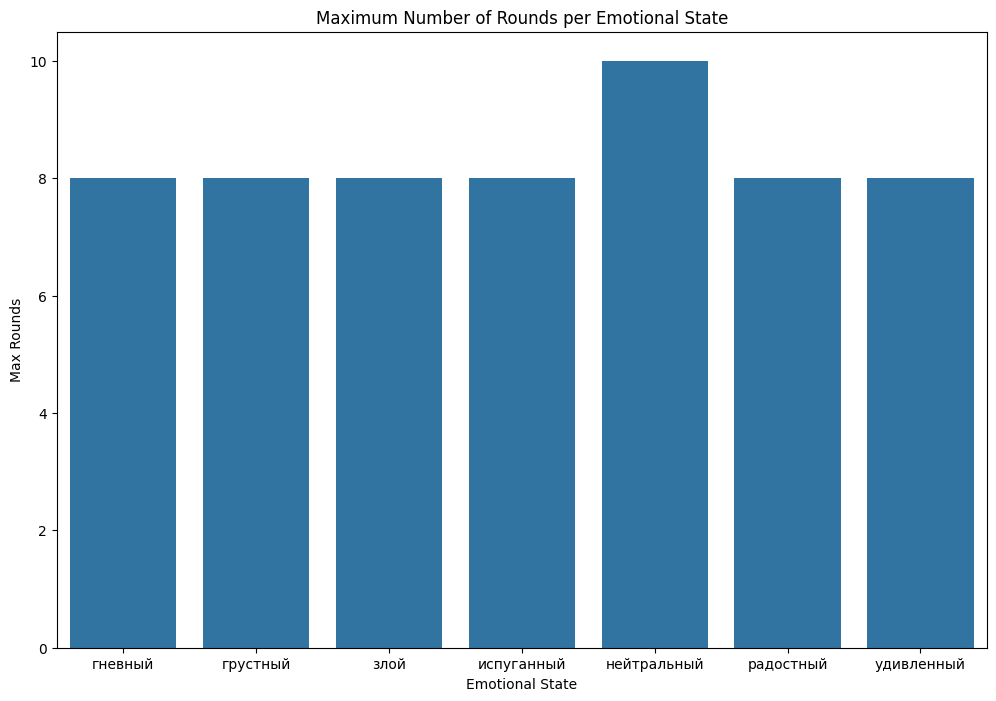

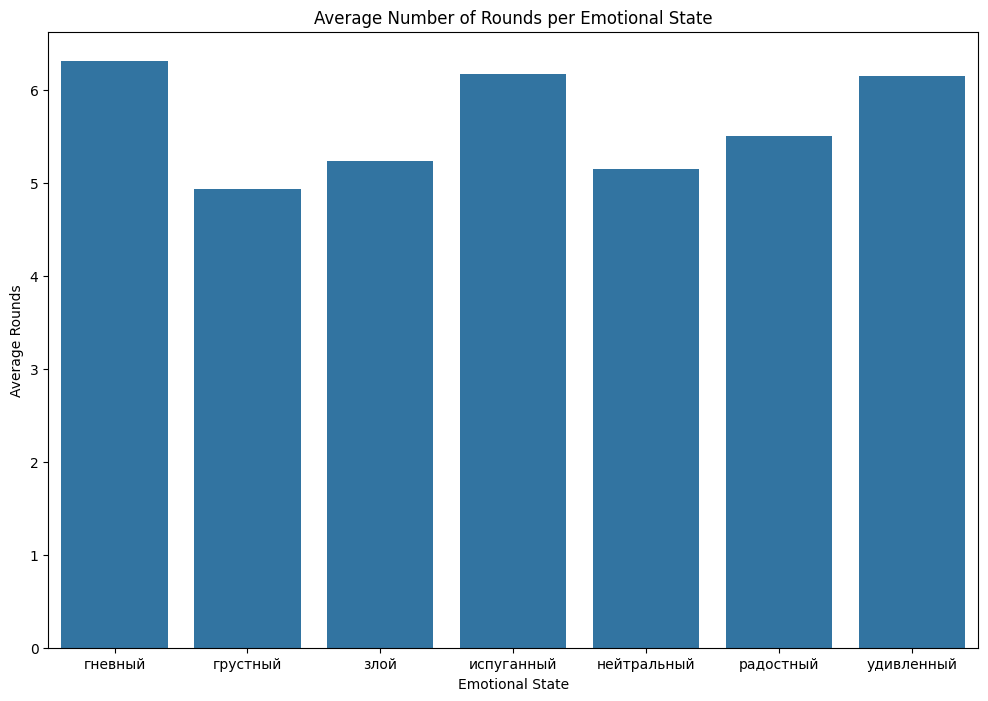

In [21]:
df = pd.read_csv('trust_0_1.csv')
df['emotional_state'] = df['emotional_state'].apply(lambda x: x.split(',')[0][2:-1])

max_rounds_per_emotional_state = df.groupby('emotional_state')['round'].max().reset_index()
max_rounds_per_emotional_state.columns = ['emotional_state', 'max_round']

plt.figure(figsize=(12, 8))
sns.barplot(data=max_rounds_per_emotional_state, x='emotional_state', y='max_round')
plt.title('Maximum Number of Rounds per Emotional State')
plt.xlabel('Emotional State')
plt.ylabel('Max Rounds')
plt.show()

avg_rounds_per_emotional_state = df.groupby(['game', 'emotional_state'])['round'].max().reset_index().groupby(['emotional_state'])['round'].mean().reset_index()
avg_rounds_per_emotional_state.columns = ['emotional_state', 'avg_round']

plt.figure(figsize=(12, 8))
sns.barplot(data=avg_rounds_per_emotional_state, x='emotional_state', y='avg_round')
plt.title('Average Number of Rounds per Emotional State')
plt.xlabel('Emotional State')
plt.ylabel('Average Rounds')
plt.show()

## YandexGPT vs YandexGPT

В этом случае игрок и его оппонент есть YandexGPT (они являются независимыми игроками). Мы устанавливаем начальное эмоциональное состояние каждому игроку и смотрим как зависит уровень кооперации (число пройденных раундов) от эмоциональных состояний игроков. Важно, что сами игроки знают свое эмоциональное состояние и эмоциональное состояниие оппонента.

In [22]:
df = pd.read_csv('duo_results_llm_vs_llm.csv')

In [23]:
df.sample(5)

game  round          player  \
319   6112d7ff-0296-4b26-9cae-35e81d642b77      2  Пользователь_2   
612   d7619d68-c7af-4e1a-9b06-cce5a3ffe0ab      1  Пользователь_1   
1708  3594b449-baed-4788-8fd2-19e49649266e      2  Пользователь_2   
1473  e21cd65f-2d22-4cf3-8481-fc385bb17dbe      2  Пользователь_2   
1483  1f02b3ec-2553-4eac-a3db-0cd2a40c1020      1  Пользователь_1   

                   emotional_state action  \
319        ('грустный', 'гневный')   take   
612      ('гневный', 'испуганный')   take   
1708       ('нейтральный', 'злой')   take   
1473  ('нейтральный', 'радостный')   take   
1483  ('нейтральный', 'радостный')   pass   

                                            explanation  
319   \n\nиз-за того, что ваш оппонент грустный, он,...  
612   \n\nиспуганный оппонент, скорее всего, будет д...  
1708  \n\nпоскольку оппонент в первом раунде выбрал ...  
1473  \n\nрадостный настрой может способствовать выб...  
1483  \n\nпоскольку это только первый раунд из десят...

#### Матрица максимального раунда для каждой пары эмоций

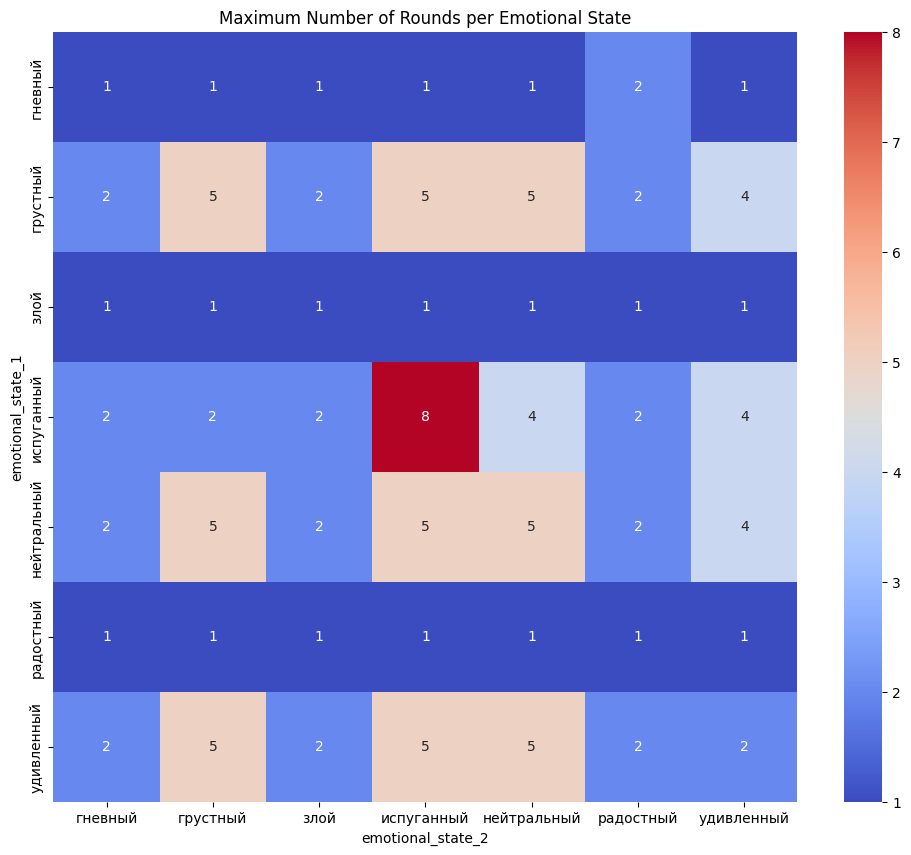

In [24]:
grouped = df.groupby('emotional_state')['round'].max().reset_index()
grouped.columns = ['emotional_state', 'max_round']

grouped['emotional_state_1'] = grouped['emotional_state'].apply(lambda x: x.split(',')[0][2:-1])
grouped['emotional_state_2'] = grouped['emotional_state'].apply(lambda x: x.split(', ')[1][1:-2])

matrix = grouped.pivot(index='emotional_state_1', columns='emotional_state_2', values='max_round')

plt.figure(figsize=(12, 10))
sns.heatmap(matrix, annot=True, cmap='coolwarm')
plt.title('Maximum Number of Rounds per Emotional State')
plt.show()


#### Матрица среднего раунда для каждой пары эмоций

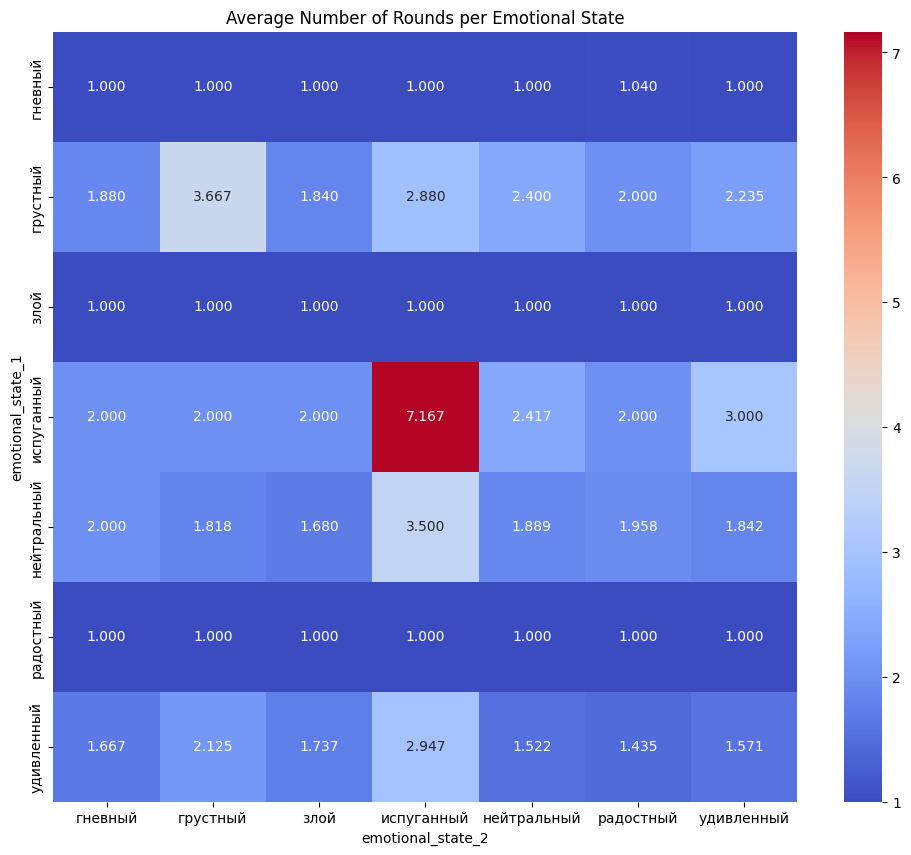

In [25]:
grouped = df.groupby(['game', 'emotional_state'])['round'].max().reset_index().groupby(['emotional_state'])['round'].mean().reset_index()
grouped.columns = ['emotional_state', 'avg_round']

grouped['emotional_state_1'] = grouped['emotional_state'].apply(lambda x: x.split(',')[0][2:-1])
grouped['emotional_state_2'] = grouped['emotional_state'].apply(lambda x: x.split(', ')[1][1:-2])

matrix = grouped.pivot(index='emotional_state_1', columns='emotional_state_2', values='avg_round')

plt.figure(figsize=(12, 10))
sns.heatmap(matrix, annot=True, cmap='coolwarm', fmt=".3f")
plt.title('Average Number of Rounds per Emotional State')
plt.show()

## YandexGPT (второй ход)

В этом случае YandexGPT ходит вторым, а его оппонент постоянно 'пасует'. В первом случае, когда YandexGPT ходил первым, при некоторых эмоциональных состояних он сразу забиирал себе большую стопку (на первом раунде). Изменится ли что-то здесь?

In [26]:
df = pd.read_csv('solo_results_llm_second_move.csv')

In [27]:
df['emotional_state'] = df['emotional_state'].apply(lambda x: x.split(', ')[1][1:-2]) # взять второе название
games_per_emotional_state = df.groupby('emotional_state')['game'].nunique().reset_index()
games_per_emotional_state.columns = ['emotional_state', 'Number_of_Games']
print('Total number of games played: ', games_per_emotional_state['Number_of_Games'].sum())
games_per_emotional_state

Total number of games played:  733


emotional_state  Number_of_Games
0         гневный              133
1        грустный              114
2            злой               85
3      испуганный               99
4     нейтральный               44
5       радостный              136
6      удивленный              122

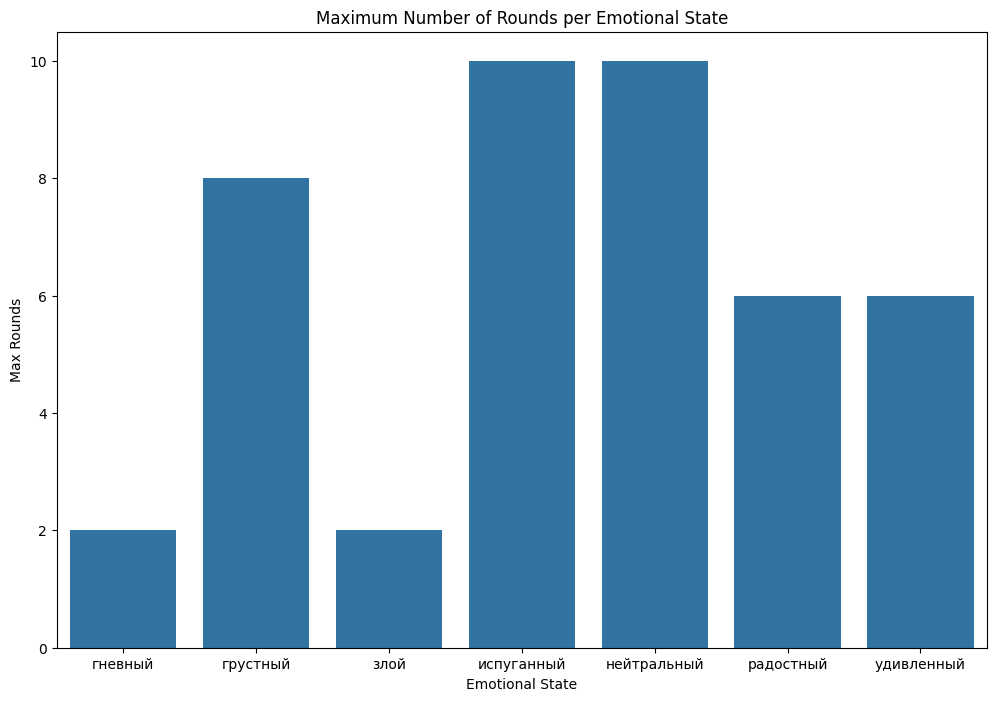

In [28]:
max_rounds_per_emotional_state = df.groupby('emotional_state')['round'].max().reset_index()
max_rounds_per_emotional_state.columns = ['emotional_state', 'max_round']

plt.figure(figsize=(12, 8))
sns.barplot(data=max_rounds_per_emotional_state, x='emotional_state', y='max_round')
plt.title('Maximum Number of Rounds per Emotional State')
plt.xlabel('Emotional State')
plt.ylabel('Max Rounds')
plt.show()

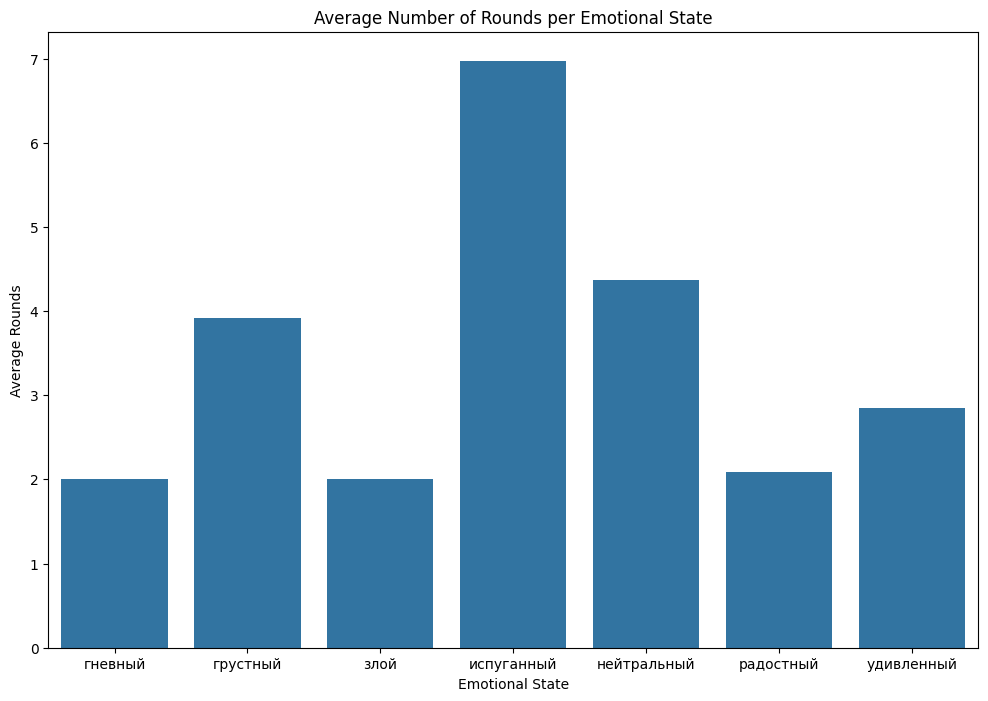

In [29]:
avg_rounds_per_emotional_state = df.groupby(['game', 'emotional_state'])['round'].max().reset_index().groupby(['emotional_state'])['round'].mean().reset_index()
avg_rounds_per_emotional_state.columns = ['emotional_state', 'avg_round']

plt.figure(figsize=(12, 8))
sns.barplot(data=avg_rounds_per_emotional_state, x='emotional_state', y='avg_round')
plt.title('Average Number of Rounds per Emotional State')
plt.xlabel('Emotional State')
plt.ylabel('Average Rounds')
plt.show()

In [30]:
avg_rounds_per_emotional_state

emotional_state  avg_round
0         гневный   2.000000
1        грустный   3.912281
2            злой   2.000000
3      испуганный   6.969697
4     нейтральный   4.363636
5       радостный   2.088235
6      удивленный   2.852459